<a href="https://colab.research.google.com/github/JoeJiraWat/Ai-Builders/blob/main/Ai_files/Signal_Autotune_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




*   Data collection เก็บข้อมูลอะไรบ้างเพื่ออะไรเช่น Audio ที่ร้องเพลงถูกคีย์, Audio ของผู้ใช้งานที่มีโอกาสเกิดขึ้นจริง เช่น data audio จากเพื่อนและคนรู้จัก
*   ในกรณีที่ได้ datasets นี้มาจะทำให้รู้ว่า data เป็นยังไงมี Noise เยอะมั้ยถ้าผู้ใช้งานใช้จริง,
*   ถ้าพบว่า Noise เยอะ ต้องลองดูวิธีกรอง noise เช่น low pass filter frequency cut-off ที่ตรงไหน,
*  Background information: Prototype ของเราจะคัดแยกคีย์ประเภทอะไรบ้าง แต่ละคีย์มีลักษณะต่างกันยังไง สามารถสังเกตได้จากอะไรบ้างจุดนี้แนะนำให้ทำ Time domain และ fraqency domain เพื่อดูลักษณะของ Ampitude,
* Modeling แล้วจึงดูต่อไปเรื่องของการทำ Model อีกทีอาจจะเป็น model ที่เคยทำไปแล้วก็ได้ถ้ามันสามารถแก้ไขปัญหาได้จริง


In [2]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
from sklearn.decomposition import FastICA
import IPython
import IPython.display as ipd
from scipy.fft import fft, fftfreq, ifft, ifftshift
from scipy.signal import butter, lfilter, freqz

# แบบเก่า

In [ ]:
#load audio file
audio_file_path = '/content/drive/MyDrive/Datasets_For_Ai_builders/เสียงกูเอง (1).wav'
sampling_rate = 10000
original_signal_y = np.array([])

In [ ]:
try:
    original_signal_y, sampling_rate = librosa.load(audio_file_path, sr=None)
    print(f"Sampling Rate: {sampling_rate} Hz, จำนวน Samples: {len(original_signal_y)}")
    # ลดขนาดสัญญาณถ้ามันยาวเกินไป เพื่อให้ FFT และ filter ทำงานเร็วขึ้นสำหรับตัวอย่างนี้
    if len(original_signal_y) > sampling_rate * 10: # ถ้าสัญญาณยาวกว่า 10 วินาที
        original_signal_y = original_signal_y[:sampling_rate * 10]
        print(f"ตัดสัญญาณเหลือ {len(original_signal_y)/sampling_rate:.2f} วินาที เพื่อการประมวลผลที่เร็วขึ้น")
except Exception as e:
    #จะสร้างสัญญาณทดลอง (sine wave + noise) ขึ้นมาแทน
    sampling_rate = 44100
    duration = 2.0
    time_axis = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    signal_50hz = 0.7 * np.sin(2 * np.pi * 50 * time_axis)    # ความถี่ 50 Hz
    signal_500hz = 0.5 * np.sin(2 * np.pi * 500 * time_axis)  # ความถี่ 500 Hz
    signal_5000hz = 0.3 * np.sin(2 * np.pi * 5000 * time_axis) # ความถี่ 5000 Hz
    noise = 0.2 * np.random.randn(len(time_axis))
    original_signal_y = signal_50hz + signal_500hz + signal_5000hz + noise
    print(f"Sampling Rate: {sampling_rate} Hz, จำนวน Samples: {len(original_signal_y)}")

if len(original_signal_y) == 0:
    print("No Signal")
    exit()

Sampling Rate: 48000 Hz, จำนวน Samples: 11454464
ตัดสัญญาณเหลือ 10.00 วินาที เพื่อการประมวลผลที่เร็วขึ้น


ฟังก์ชันสำหรับคำนวณและเตรียมข้อมูล FFT สำหรับพล็อต

In [ ]:
def get_fft_plot_data(signal, sr):
    N = len(signal)
    if N == 0:
        return np.array([]), np.array([])

    yf = np.fft.fft(signal)
    xf = np.fft.fftfreq(N, 1 / sr)

    # เอาเฉพาะส่วนความถี่บวก และคำนวณ magnitude
    # เราจะ plot แค่ครึ่งเดียวของ spectrum เพราะมันสมมาตร
    positive_freq_indices = np.where(xf >= 0)
    xf_positive = xf[positive_freq_indices]
    yf_magnitude_positive = np.abs(yf[positive_freq_indices])

    return xf_positive, yf_magnitude_positive


คำนวณ FFT ของสัญญาณต้นฉบับ

In [ ]:
xf_original, yf_mag_original = get_fft_plot_data(original_signal_y, sampling_rate)


Low-pass Butterworth Filter

In [ ]:
cutoff_freq = 2000  # Hz (ความถี่ที่จะเริ่มตัดออก, สัญญาณความถี่สูงกว่านี้จะถูกลดทอน)
filter_order = 5    # Order ของฟิลเตอร์ (ยิ่งสูง ยิ่งชัน แต่ก็อาจมีปัญหา phase shift มากขึ้น)

# Nyquist frequency (ความถี่สูงสุดที่เราสามารถแทนได้ คือครึ่งหนึ่งของ sampling rate)
nyq = 0.5 * sampling_rate

In [ ]:
if cutoff_freq >= nyq:
    print(f" Cutoff frequency ({cutoff_freq} Hz) สูงหรือเท่ากับ Nyquist frequency ({nyq} Hz).")
    # ในกรณีนี้ เราอาจจะไม่ฟิลเตอร์ หรือใช้สัญญาณเดิมไปเลย
    filtered_signal_y = original_signal_y # หรือจัดการอย่างอื่นตามความเหมาะสม
else:
    normal_cutoff = cutoff_freq / nyq # ทำให้ cutoff frequency เป็นค่า normalized (0 ถึง 1)

    # b, a คือ coefficients ของฟิลเตอร์ ( числитель และ знаменатель ของ transfer function)
    # สำหรับ IIR filters เช่น Butterworth
    b, a = butter(filter_order, normal_cutoff, btype='low', analog=False)

    # --- 4. นำฟิลเตอร์ไปใช้กับสัญญาณต้นฉบับ ---
    # lfilter ใช้ b, a coefficients เพื่อฟิลเตอร์สัญญาณ
    filtered_signal_y = lfilter(b, a, original_signal_y)


คำนวณ FFT ของสัญญาณที่ผ่านฟิลเตอร์

In [ ]:
xf_filtered, yf_mag_filtered = get_fft_plot_data(filtered_signal_y, sampling_rate)


plot graph

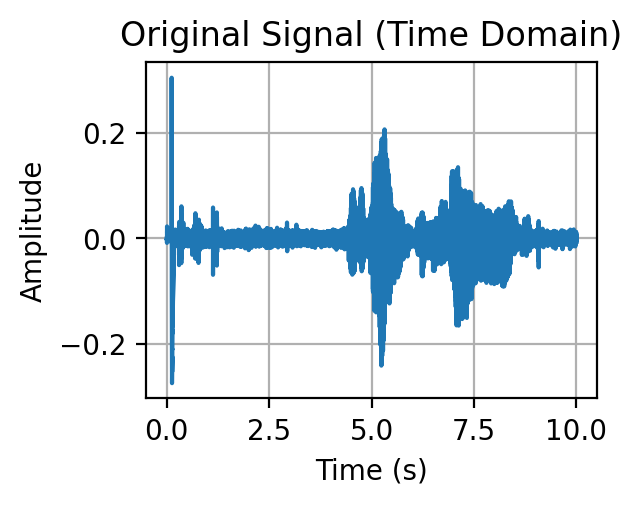

In [ ]:
# กราฟที่ 1: สัญญาณต้นฉบับในโดเมนเวลา
plt.subplot(2, 2, 1) # (2 แถว, 2 คอลัมน์, vị tríที่ 1)
time_axis_original = np.linspace(0, len(original_signal_y) / sampling_rate, num=len(original_signal_y))
plt.plot(time_axis_original, original_signal_y)
plt.title('Original Signal (Time Domain)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

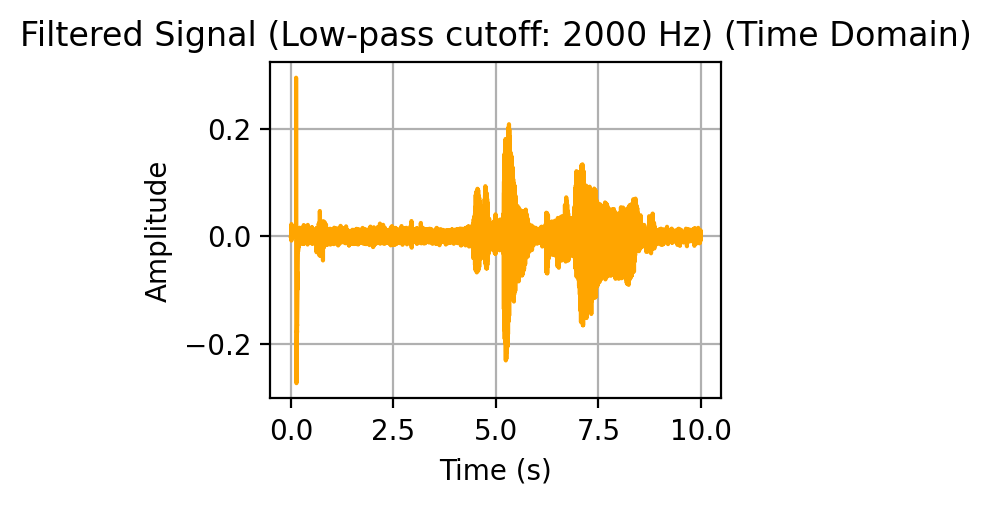

In [ ]:
# กราฟที่ 2: สัญญาณที่ผ่านฟิลเตอร์ในโดเมนเวลา
plt.subplot(2, 2, 2)
time_axis_filtered = np.linspace(0, len(filtered_signal_y) / sampling_rate, num=len(filtered_signal_y))
plt.plot(time_axis_filtered, filtered_signal_y, color='orange')
plt.title(f'Filtered Signal (Low-pass cutoff: {cutoff_freq} Hz) (Time Domain)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

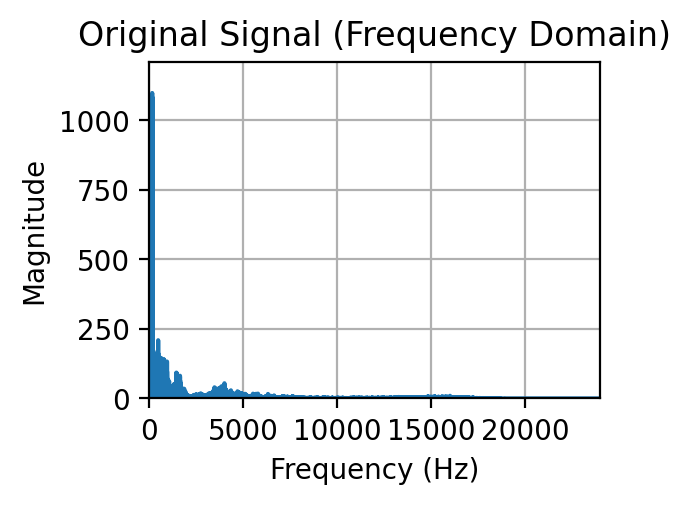

In [ ]:
# กราฟที่ 3: สเปกตรัมความถี่ของสัญญาณต้นฉบับ
plt.subplot(2, 2, 3)
if len(xf_original) > 0:
    plt.plot(xf_original, yf_mag_original)
    plt.title('Original Signal (Frequency Domain)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xlim(0, sampling_rate / 2) # แสดงถึง Nyquist frequency
    plt.ylim(0, np.max(yf_mag_original) * 1.1 if len(yf_mag_original) > 0 else 1) # ปรับแกน Y
    plt.grid(True)

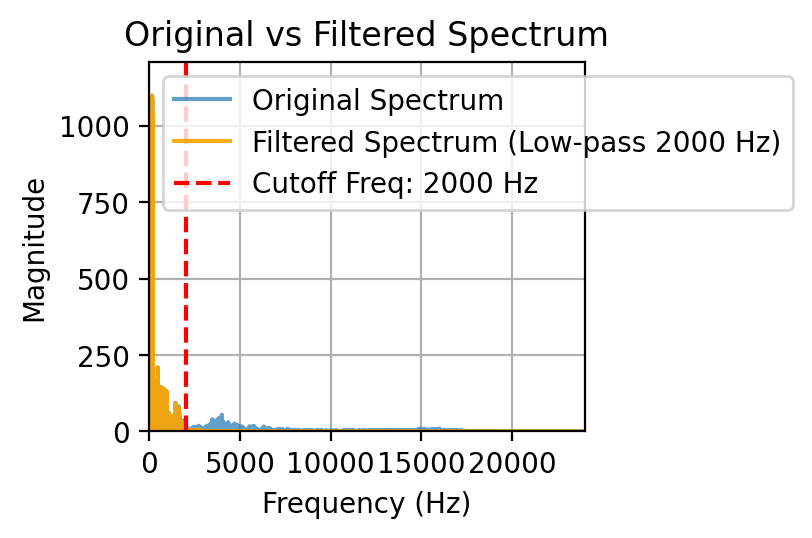

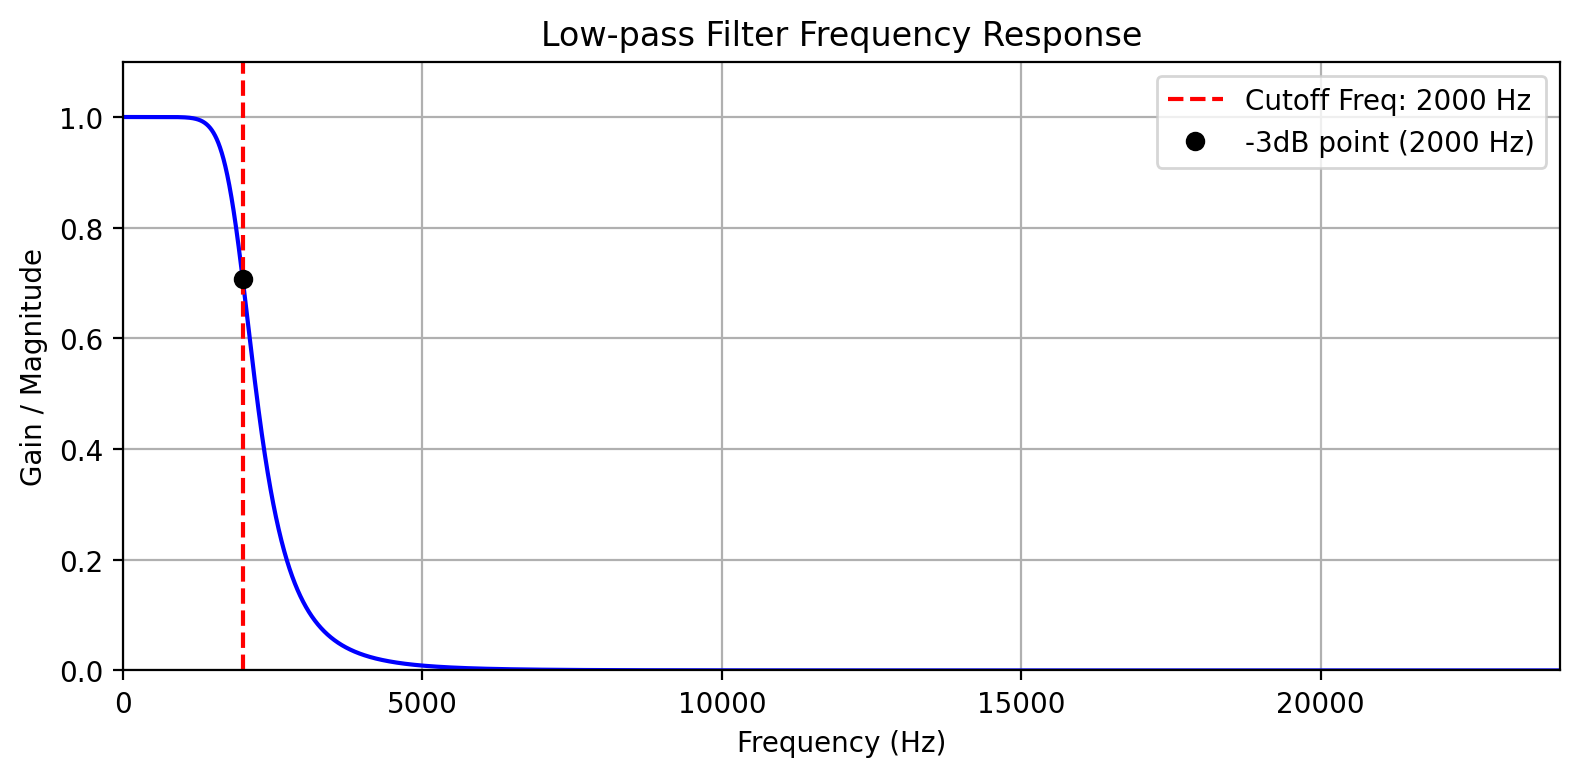

In [ ]:
# กราฟที่ 4: สเปกตรัมความถี่ของสัญญาณต้นฉบับ และ สัญญาณที่ผ่านฟิลเตอร์ (ซ้อนกัน)
plt.subplot(2, 2, 4)
if len(xf_original) > 0:
    plt.plot(xf_original, yf_mag_original, label='Original Spectrum', alpha=0.7)
if len(xf_filtered) > 0:
    plt.plot(xf_filtered, yf_mag_filtered, label=f'Filtered Spectrum (Low-pass {cutoff_freq} Hz)', color='orange', alpha=0.9)
plt.title('Original vs Filtered Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, sampling_rate / 2) # แสดงถึง Nyquist frequency
# ปรับแกน Y ให้เห็นทั้งสอง spectrum
max_mag = 0
if len(yf_mag_original) > 0: max_mag = max(max_mag, np.max(yf_mag_original))
if len(yf_mag_filtered) > 0: max_mag = max(max_mag, np.max(yf_mag_filtered))
plt.ylim(0, max_mag * 1.1 if max_mag > 0 else 1)

plt.axvline(cutoff_freq, color='r', linestyle='--', label=f'Cutoff Freq: {cutoff_freq} Hz') # เส้นแสดง cutoff freq
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# (เสริม) พล็อต Frequency Response ของฟิลเตอร์เอง (ถ้าต้องการดู)
if 'b' in locals() and 'a' in locals() and cutoff_freq < nyq: # ตรวจสอบว่า b, a ถูกสร้างหรือยัง
    w, h = freqz(b, a, worN=8000, fs=sampling_rate) # worN คือจำนวนจุดความถี่ที่จะคำนวณ
    plt.figure(figsize=(8,4))
    plt.plot(w, np.abs(h), 'b')
    plt.axvline(cutoff_freq, color='r', linestyle='--', label=f'Cutoff Freq: {cutoff_freq} Hz')
    plt.plot(cutoff_freq, 0.5*np.sqrt(2), 'ko', label=f'-3dB point ({cutoff_freq} Hz)') # จุด -3dB
    plt.title("Low-pass Filter Frequency Response")
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain / Magnitude')
    plt.grid(True)
    plt.legend()
    plt.xlim(0, sampling_rate/2)
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()

In [ ]:
from scipy.signal import butter, lfilter, freqz

In [ ]:
# เพื่อให้เห็นผลของฟิลเตอร์ชัดเจน สร้างสัญญาณที่มีหลายความถี่
sampling_rate = 44100
duration = 2.0
time_axis = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

freq1 = 50      # Hz
freq2 = 500     # Hz
freq3 = 2000    # Hz
freq4 = 8000    # Hz

signal_f1 = 1.0 * np.sin(2 * np.pi * freq1 * time_axis)
signal_f2 = 0.8 * np.sin(2 * np.pi * freq2 * time_axis)
signal_f3 = 0.6 * np.sin(2 * np.pi * freq3 * time_axis)
signal_f4 = 0.4 * np.sin(2 * np.pi * freq4 * time_axis)
noise = 0.1 * np.random.randn(len(time_axis))

original_signal_y = signal_f1 + signal_f2 + signal_f3 + signal_f4 + noise
print(f"Sampling Rate: {sampling_rate} Hz, จำนวน Samples: {len(original_signal_y)}")
print(f"ยความถี่: {freq1} Hz, {freq2} Hz, {freq3} Hz, {freq4} Hz และ noise")

Sampling Rate: 44100 Hz, จำนวน Samples: 88200
ยความถี่: 50 Hz, 500 Hz, 2000 Hz, 8000 Hz และ noise


In [ ]:
# --- ฟังก์ชันสำหรับคำนวณและเตรียมข้อมูล FFT สำหรับพล็อต ---
def get_fft_plot_data(signal, sr):
    N = len(signal)
    if N == 0:
        return np.array([]), np.array([])
    yf = np.fft.fft(signal)
    xf = np.fft.fftfreq(N, 1 / sr)
    positive_freq_indices = np.where(xf >= 0)
    xf_positive = xf[positive_freq_indices]
    yf_magnitude_positive = np.abs(yf[positive_freq_indices])
    return xf_positive, yf_magnitude_positive


In [ ]:
# --- ฟังก์ชันสำหรับออกแบบ, ใช้, และพล็อตฟิลเตอร์ ---
def apply_and_plot_filter(signal_in, sr, filter_type, cutoff_freqs, order, filter_name):
    nyq = 0.5 * sr

    # จัดการ cutoff_freqs สำหรับฟิลเตอร์แต่ละประเภท
    if filter_type == 'lowpass' or filter_type == 'highpass':
        if not isinstance(cutoff_freqs, (int, float)):
            print(f"Error: {filter_name} ต้องการ cutoff_freqs เป็นตัวเลขเดี่ยว")
            return
        if cutoff_freqs >= nyq:
            print(f"Warning: Cutoff frequency ({cutoff_freqs} Hz) สำหรับ {filter_name} สูงหรือเท่ากับ Nyquist ({nyq} Hz).")
            # อาจจะไม่ฟิลเตอร์ หรือคืนสัญญาณเดิม
            filtered_signal = signal_in
            b, a = np.array([1]), np.array([1]) # Dummy coefficients
        else:
            normal_cutoff = cutoff_freqs / nyq
            b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
            filtered_signal = lfilter(b, a, signal_in)
    elif filter_type == 'bandpass' or filter_type == 'bandstop':
        if not isinstance(cutoff_freqs, (list, tuple)) or len(cutoff_freqs) != 2:
            print(f"Error: {filter_name} ต้องการ cutoff_freqs เป็น list หรือ tuple ที่มี 2 ค่า (low, high)")
            return
        lowcut, highcut = cutoff_freqs
        if lowcut >= highcut:
            print(f"Error: Low cutoff ({lowcut}) ต้องน้อยกว่า High cutoff ({highcut}) สำหรับ {filter_name}")
            return
        if highcut >= nyq:
             print(f"Warning: High cutoff frequency ({highcut} Hz) สำหรับ {filter_name} สูงหรือเท่ากับ Nyquist ({nyq} Hz). ปรับค่า highcut.")
             highcut = nyq * 0.99 # ปรับเล็กน้อย
        if lowcut <= 0:
             print(f"Warning: Low cutoff frequency ({lowcut} Hz) สำหรับ {filter_name} ต่ำหรือเท่ากับ 0. ปรับค่า lowcut.")
             lowcut = 1 # ปรับเล็กน้อย

        normal_low = lowcut / nyq
        normal_high = highcut / nyq
        if normal_low >= normal_high: # Double check after normalization
            print(f"Error: Normalized low cutoff ({normal_low}) >= high cutoff ({normal_high}) for {filter_name}")
            return
        b, a = butter(order, [normal_low, normal_high], btype=filter_type, analog=False)
        filtered_signal = lfilter(b, a, signal_in)
    else:
        print(f"Error: ไม่รู้จัก filter_type: {filter_type}")
        return

    # เตรียมข้อมูล FFT
    xf_orig, yf_mag_orig = get_fft_plot_data(signal_in, sr)
    xf_filt, yf_mag_filt = get_fft_plot_data(filtered_signal, sr)

    # พล็อตกราฟ
    plt.figure(figsize=(15, 12))
    figure_title = f"Filter Type: {filter_name} | Cutoff(s): {cutoff_freqs} Hz | Order: {order}"
    plt.suptitle(figure_title, fontsize=16)

    # 1. Time domain: Original
    plt.subplot(3, 1, 1)
    time_ax = np.linspace(0, len(signal_in) / sr, num=len(signal_in))
    plt.plot(time_ax, signal_in, label='Original Signal', alpha=0.7)
    plt.plot(time_ax, filtered_signal, label=f'Filtered Signal ({filter_name})', color='orange', alpha=0.9)
    plt.title('Time Domain: Original vs Filtered')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.xlim(0, 0.1) # ซูมดูช่วงสั้นๆ เพื่อให้เห็น waveform ชัดขึ้น

    # 2. Frequency domain: Original vs Filtered Spectrum
    plt.subplot(3, 1, 2)
    if len(xf_orig) > 0:
        plt.plot(xf_orig, yf_mag_orig, label='Original Spectrum', alpha=0.7)
    if len(xf_filt) > 0:
        plt.plot(xf_filt, yf_mag_filt, label=f'Filtered Spectrum ({filter_name})', color='orange', alpha=0.9)

    # วาดเส้น Cutoff
    if isinstance(cutoff_freqs, (int, float)):
        plt.axvline(cutoff_freqs, color='r', linestyle='--', label=f'Cutoff: {cutoff_freqs} Hz')
    elif isinstance(cutoff_freqs, (list, tuple)) and len(cutoff_freqs) == 2:
        plt.axvline(cutoff_freqs[0], color='r', linestyle='--', label=f'Low Cut: {cutoff_freqs[0]} Hz')
        plt.axvline(cutoff_freqs[1], color='m', linestyle='--', label=f'High Cut: {cutoff_freqs[1]} Hz')

    plt.title('Frequency Domain: Original vs Filtered Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xlim(0, sr / 2)
    max_mag_display = 0
    if len(yf_mag_orig) > 0: max_mag_display = max(max_mag_display, np.max(yf_mag_orig))
    if len(yf_mag_filt) > 0: max_mag_display = max(max_mag_display, np.max(yf_mag_filt))
    plt.ylim(0, max_mag_display * 1.1 if max_mag_display > 0 else 1)
    plt.legend()
    plt.grid(True)

    # 3. Filter Frequency Response
    plt.subplot(3, 1, 3)
    w, h = freqz(b, a, worN=8000, fs=sr)
    plt.plot(w, np.abs(h), 'g')
    if isinstance(cutoff_freqs, (int, float)):
        plt.axvline(cutoff_freqs, color='r', linestyle='--', label=f'Cutoff: {cutoff_freqs} Hz')
        if cutoff_freqs < nyq : plt.plot(cutoff_freqs, 0.5*np.sqrt(2), 'ko', label='-3dB point')
    elif isinstance(cutoff_freqs, (list, tuple)) and len(cutoff_freqs) == 2:
        plt.axvline(cutoff_freqs[0], color='r', linestyle='--', label=f'Low Cut: {cutoff_freqs[0]} Hz')
        plt.axvline(cutoff_freqs[1], color='m', linestyle='--', label=f'High Cut: {cutoff_freqs[1]} Hz')
        if cutoff_freqs[0] > 0 and cutoff_freqs[0] < nyq: plt.plot(cutoff_freqs[0], 0.5*np.sqrt(2), 'ko')
        if cutoff_freqs[1] > 0 and cutoff_freqs[1] < nyq: plt.plot(cutoff_freqs[1], 0.5*np.sqrt(2), 'ko')


    plt.title(f"{filter_name} Frequency Response")
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain / Magnitude')
    plt.grid(True)
    plt.legend()
    plt.xlim(0, sr/2)
    plt.ylim(0, 1.1)

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
    plt.show()

In [ ]:
filter_order = 5

In [ ]:
#ปรับsampling rate
sampling_rate = 5000

สัญญาณ 50Hz และ 500Hz จะถูกลดทอน, 2000Hz และ 8000Hz ควรจะยังอยู่

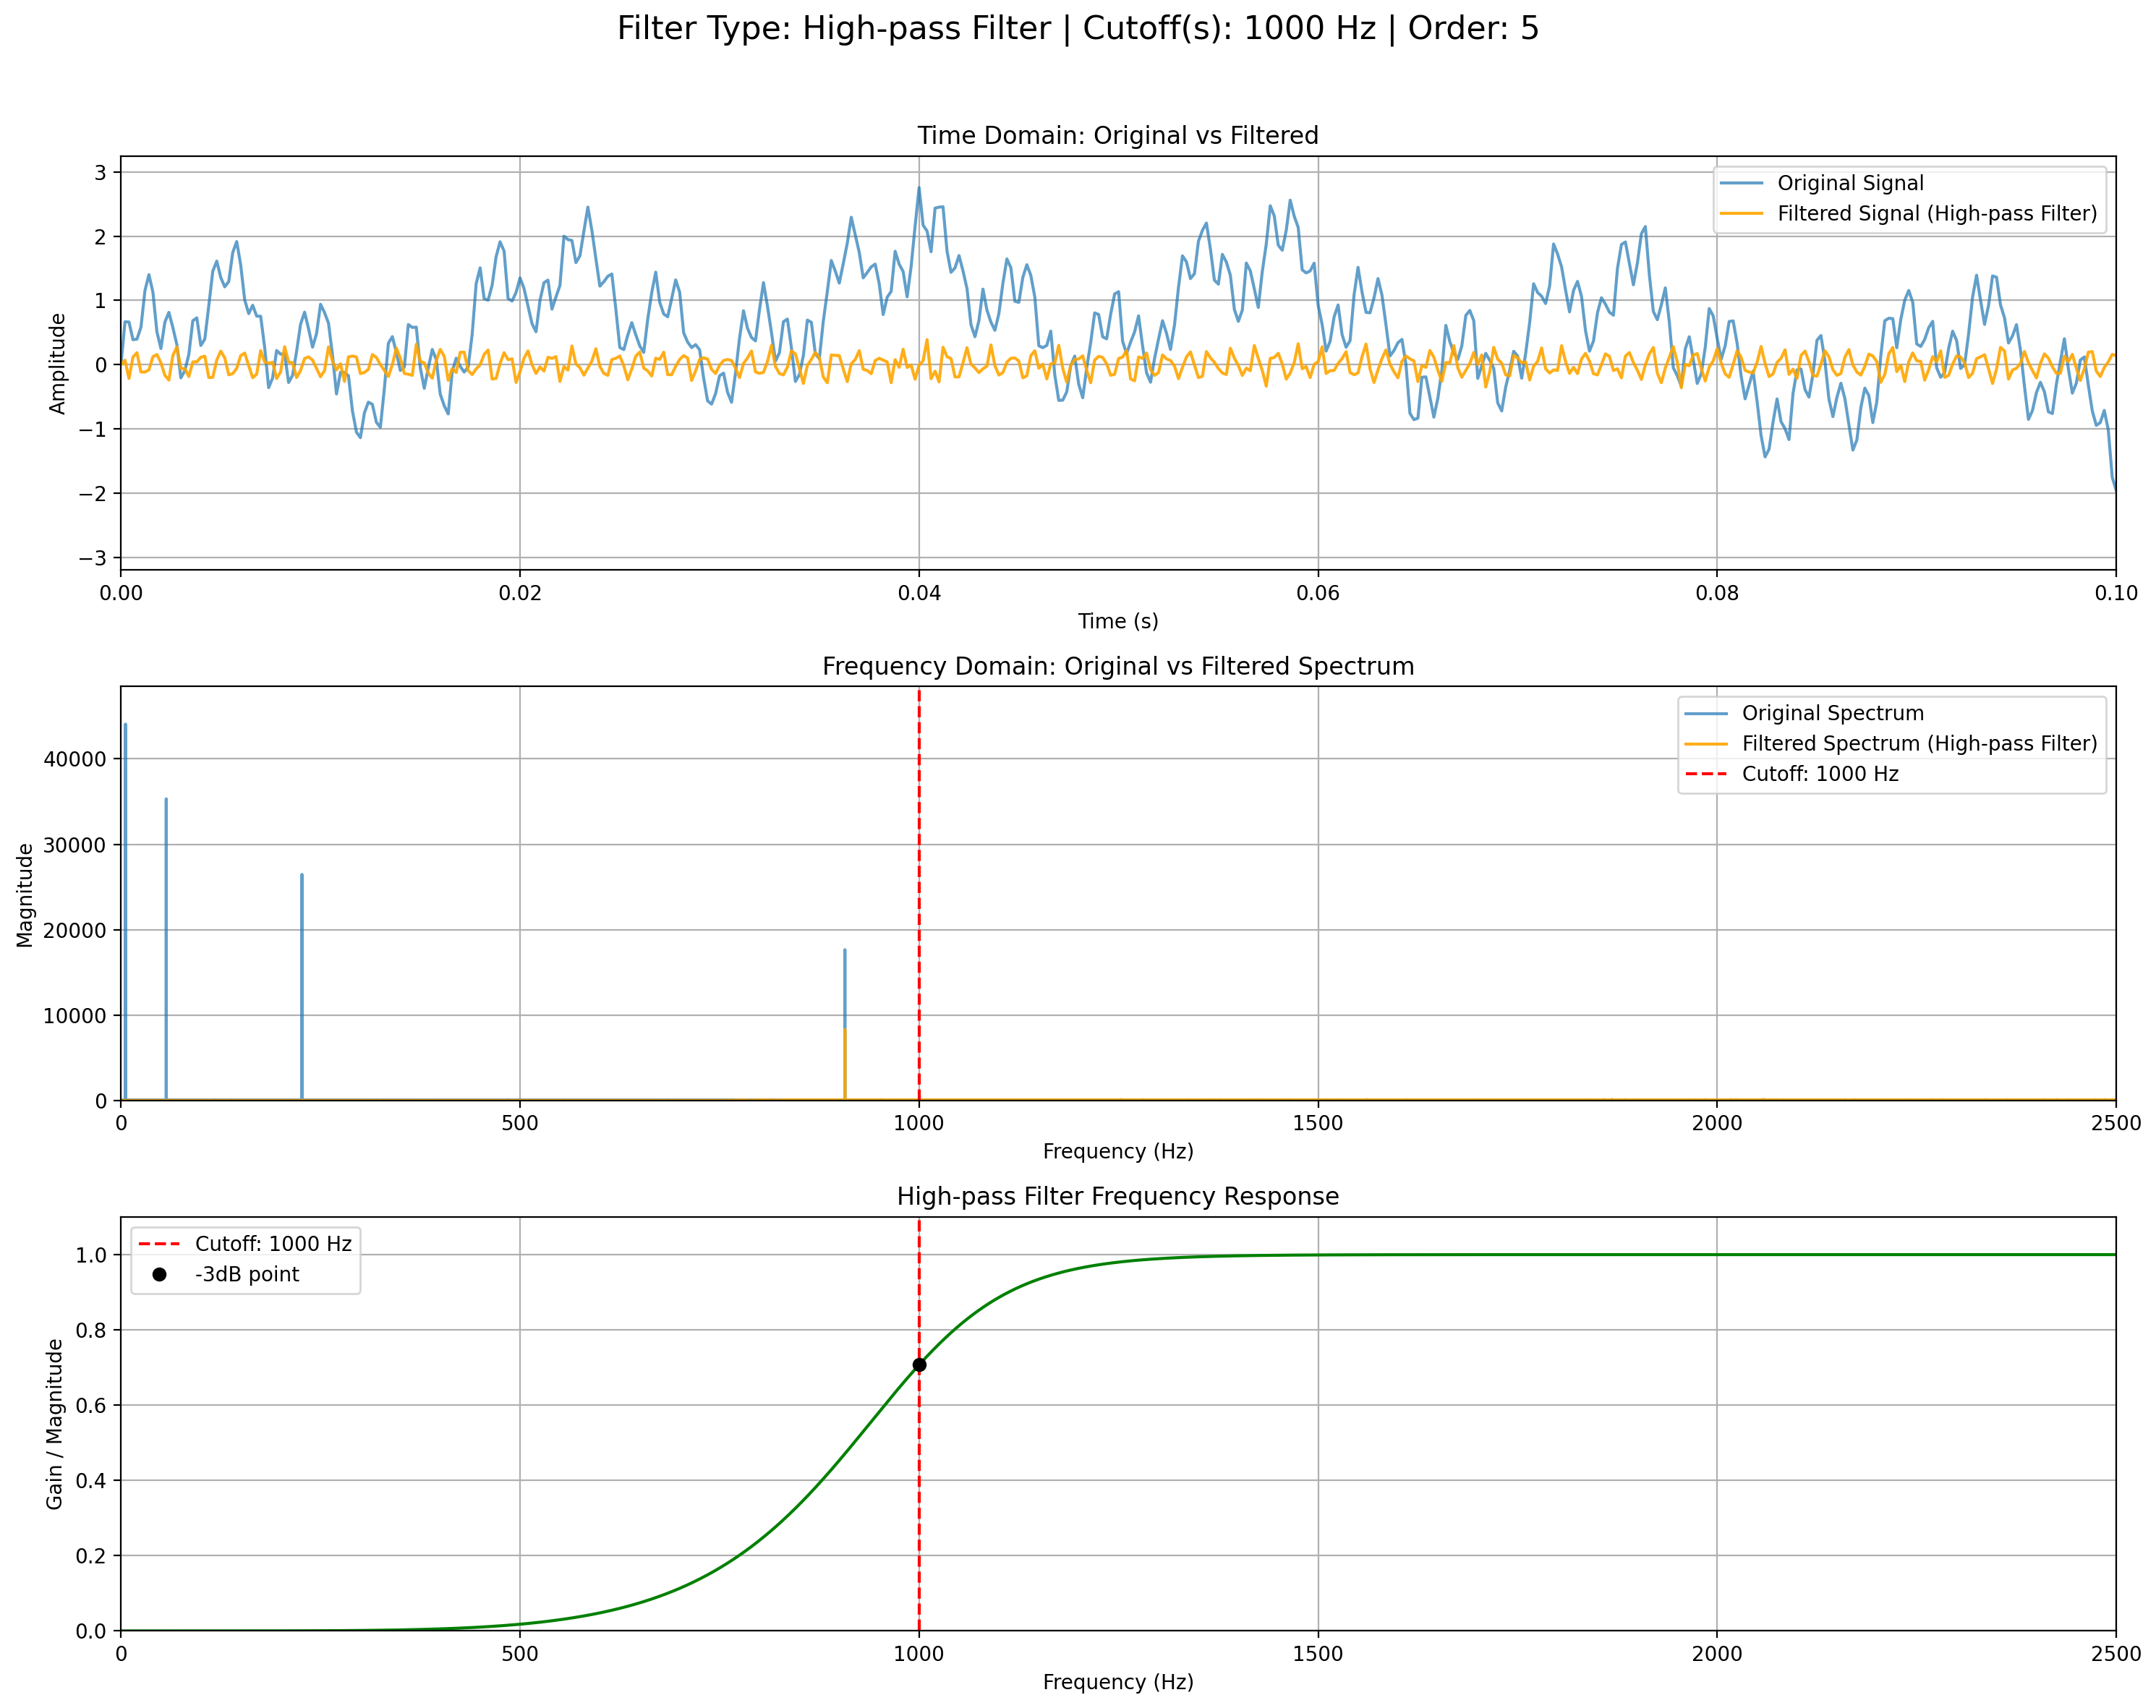

In [ ]:
# 1. High-pass Filter
hp_cutoff = 1000 # Hz (จะตัดความถี่ต่ำกว่า 1000 Hz ออก)
apply_and_plot_filter(original_signal_y, sampling_rate, 'highpass', hp_cutoff, filter_order, "High-pass Filter")

สัญญาณ 500Hz จะยังอยู่, ความถี่อื่นๆ (50, 2000, 8000Hz) จะถูกลดทอน

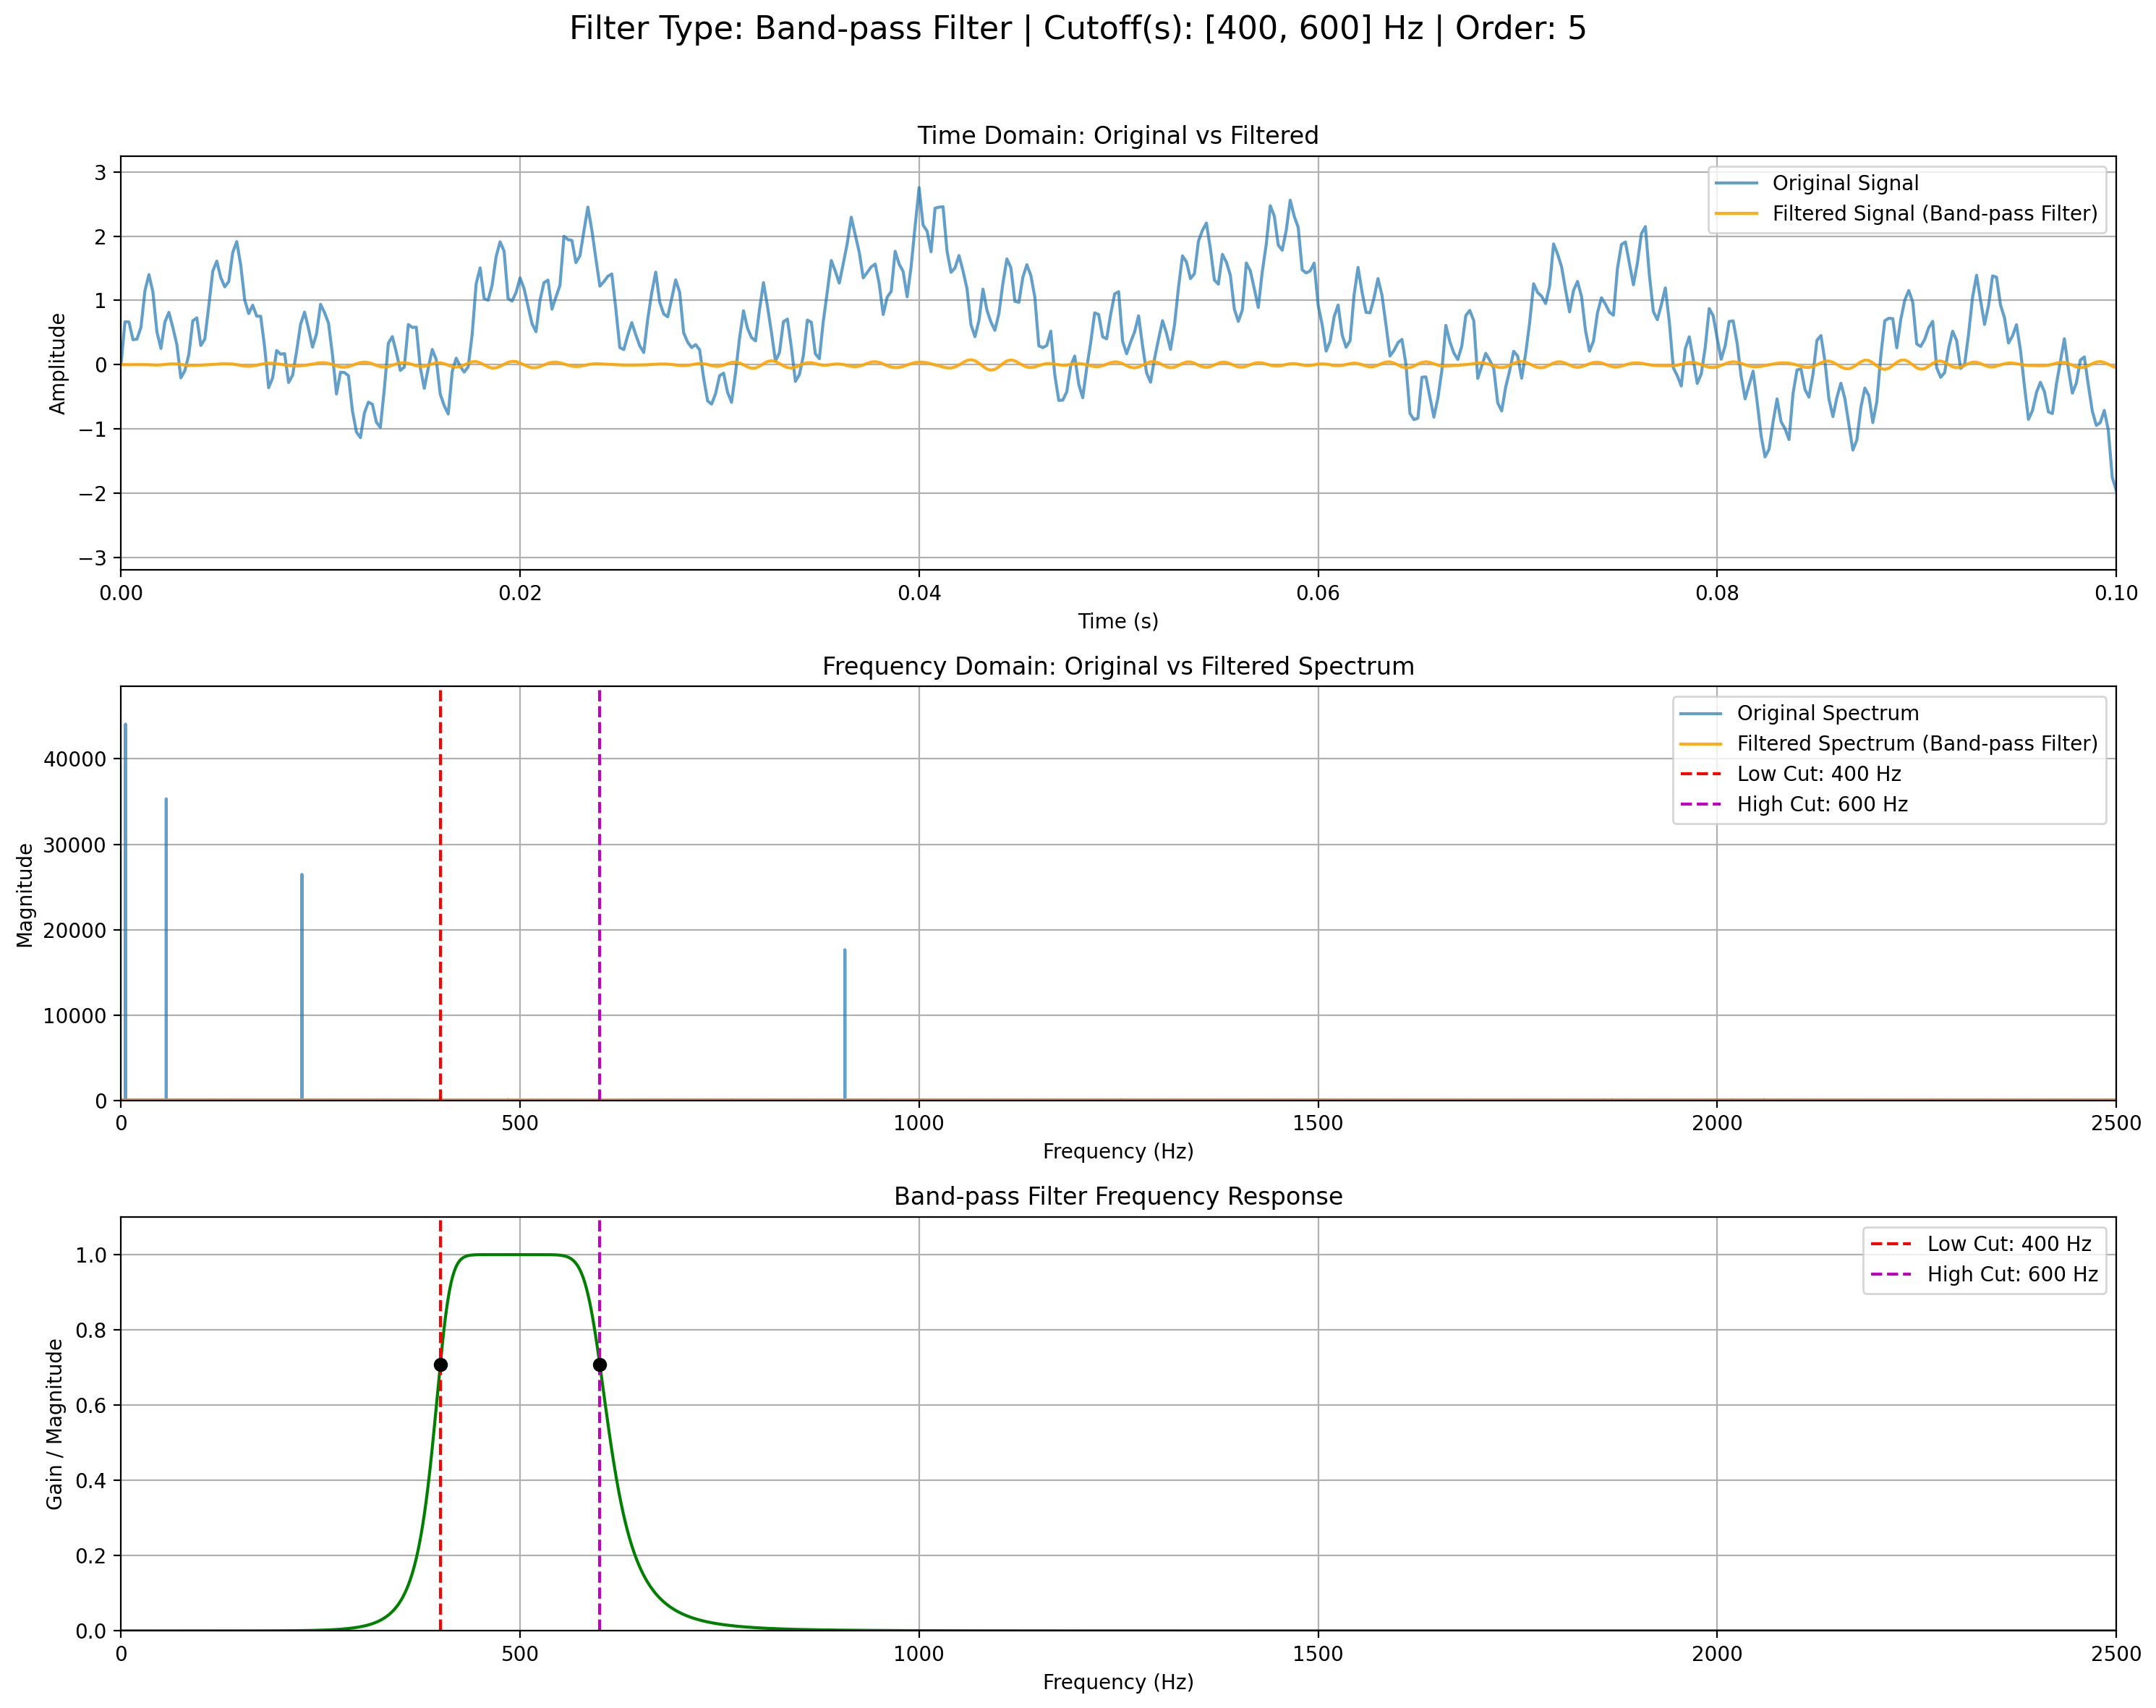

In [ ]:
# 2. Band-pass Filter
bp_cutoffs = [400, 600] # Hz (จะปล่อยให้ความถี่ระหว่าง 400-600 Hz ผ่าน, คือเน้น 500Hz)
apply_and_plot_filter(original_signal_y, sampling_rate, 'bandpass', bp_cutoffs, filter_order, "Band-pass Filter")

สัญญาณ 2000Hz จะถูกลดทอน, ความถี่อื่นๆ (50, 500, 8000Hz) ควรจะยังอยู่

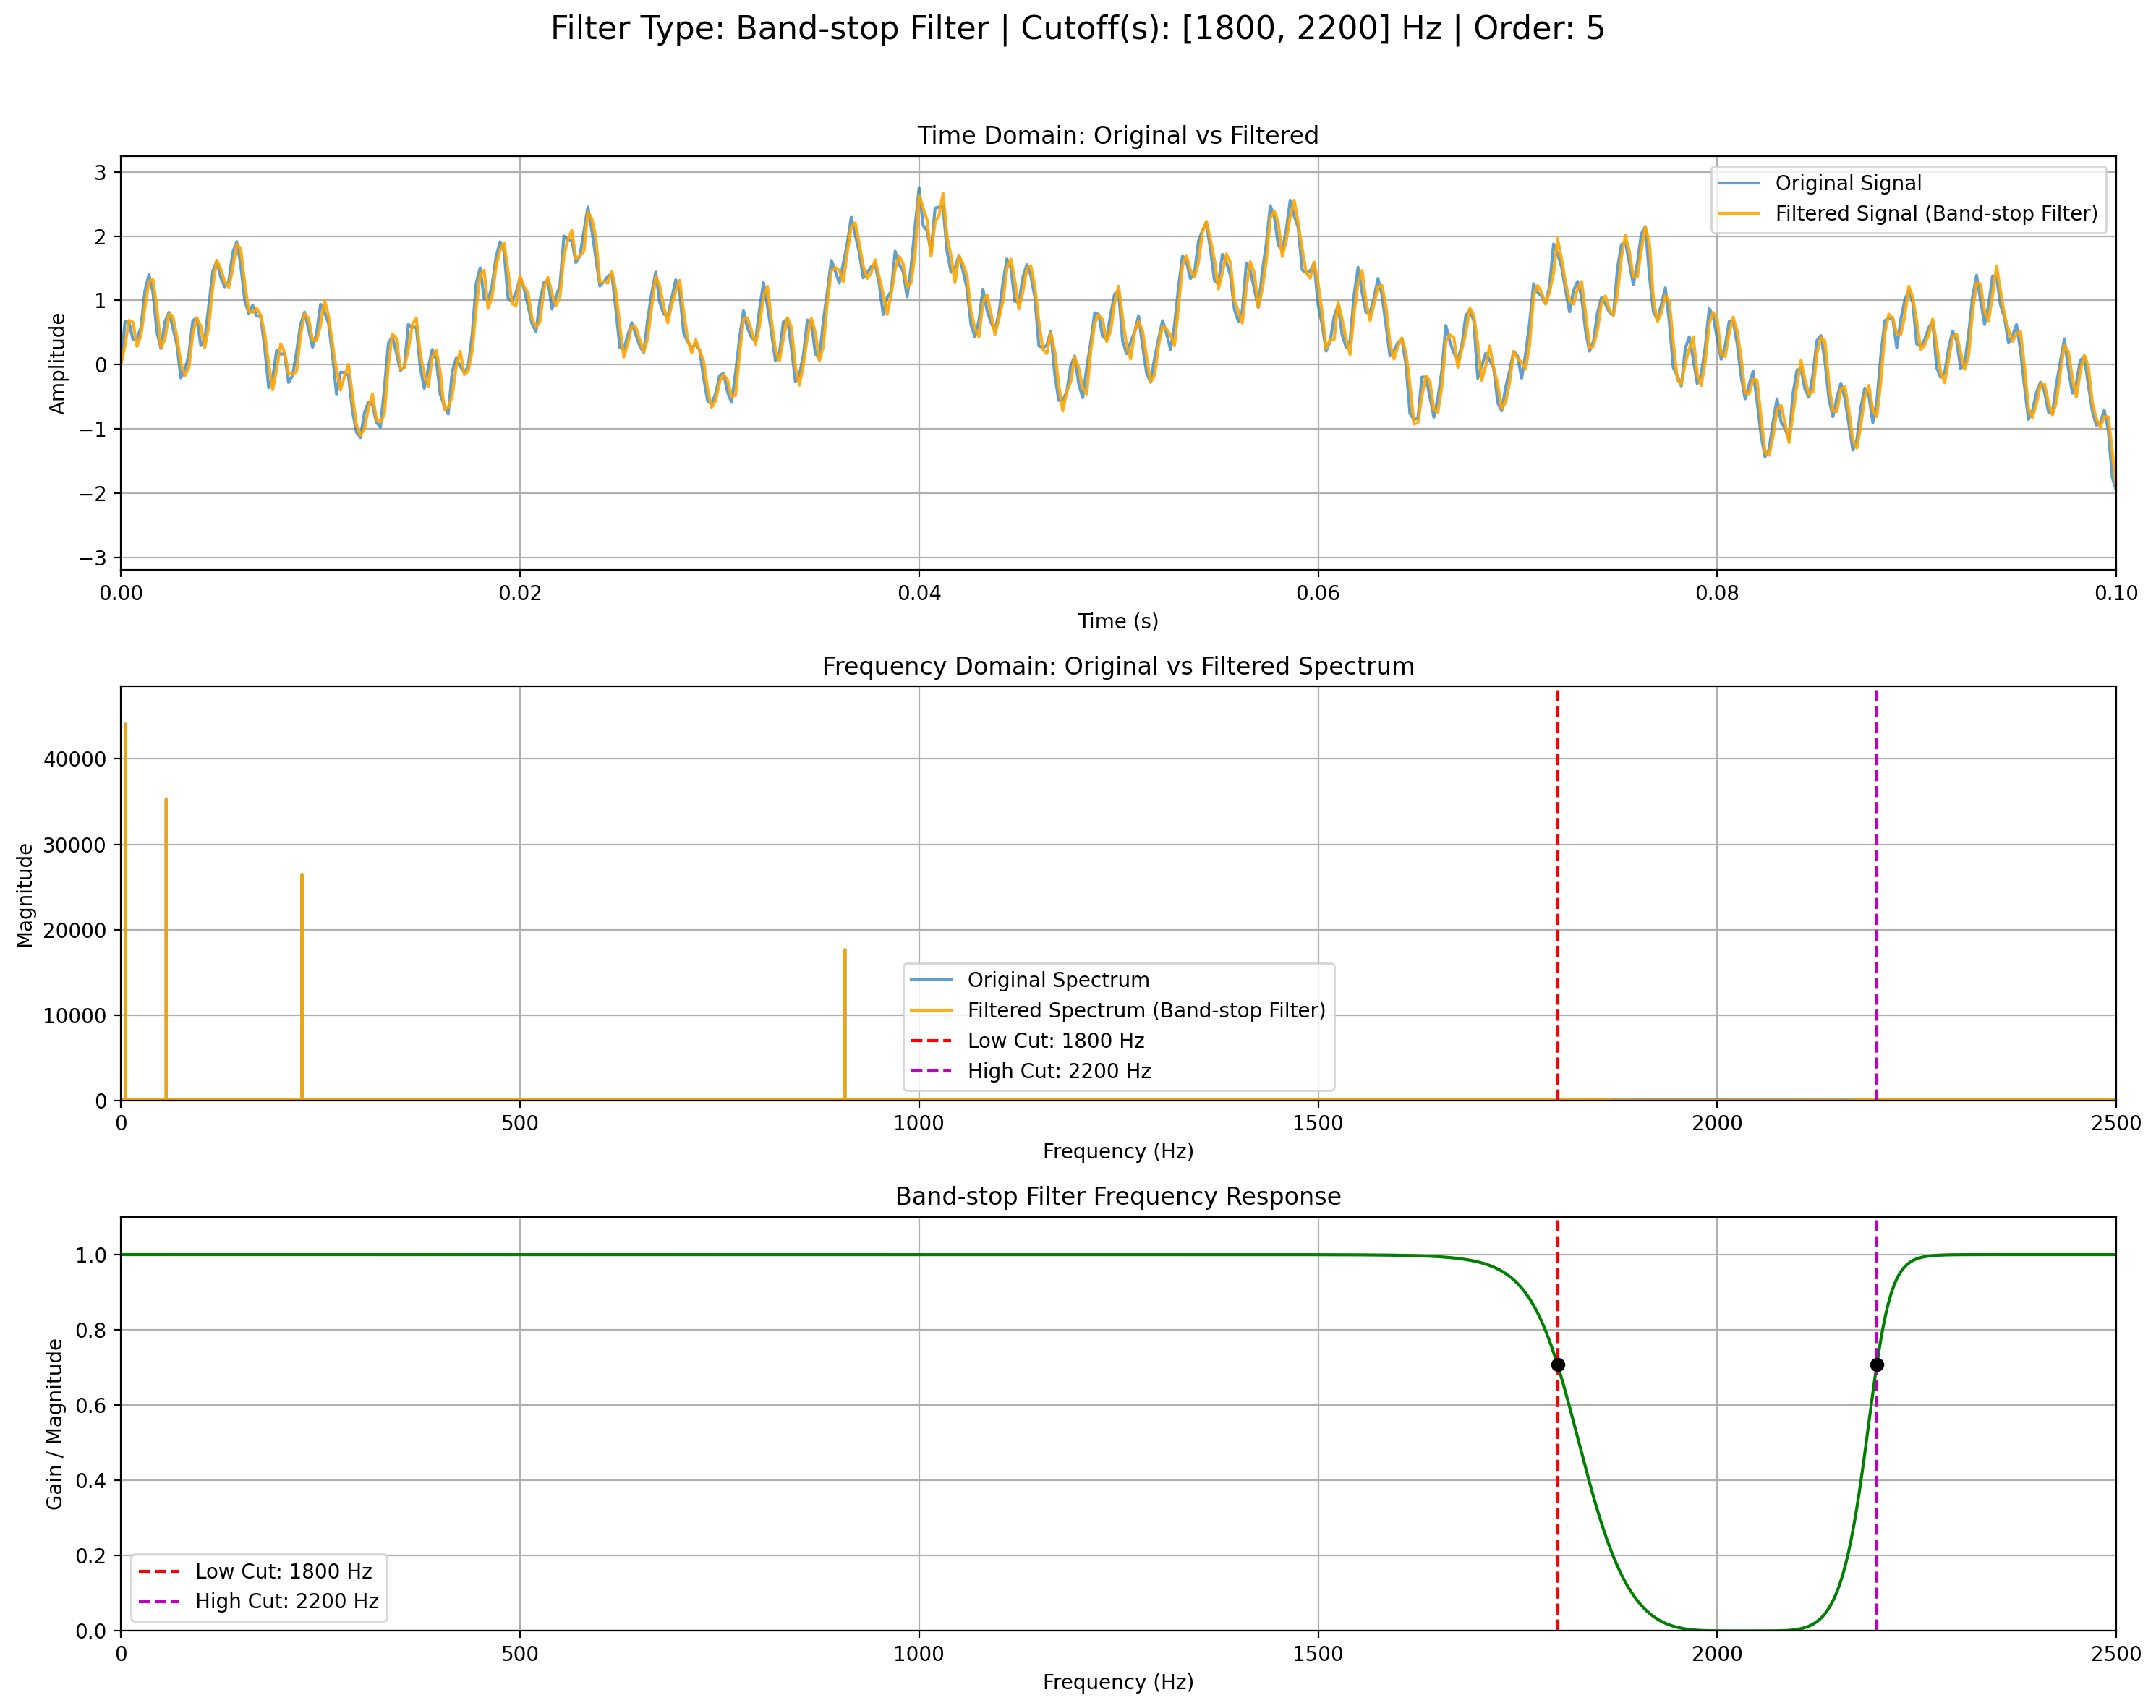

In [ ]:
# 3. Band-stop Filter (Notch Filter)
bs_cutoffs = [1800, 2200] # Hz (จะตัดความถี่ระหว่าง 1800-2200 Hz ออก, คือพยายามตัด 2000Hz)
apply_and_plot_filter(original_signal_y, sampling_rate, 'bandstop', bs_cutoffs, filter_order, "Band-stop Filter")

# กรองNoise

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import butter, filtfilt, freqz, resample

In [ ]:
path = '/content/drive/MyDrive/Datasets_For_Ai_builders/เสียงกูเอง (1)_vocal.wav'
fs_orig, data = wavfile.read(path)

แปลง mono

In [ ]:
if data.ndim > 1:
    data = data.mean(axis=1)

normalize

In [ ]:
data = data / np.max(np.abs(data))

In [ ]:
target_fs = 15000  # sampling rate
num_samples = int(len(data) * target_fs / fs_orig)
data_rs = resample(data, num_samples)
fs = target_fs
t = np.linspace(0, len(data_rs)/fs, num=len(data_rs))

In [ ]:
def butter_filter(data, cutoff, fs, btype, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype=btype)
    filtered = filtfilt(b, a, data)
    return filtered, (b, a)

In [ ]:
low_cutoff = 1000
high_cutoff = 500

In [ ]:
low_filtered, (b_low, a_low) = butter_filter(data_rs, low_cutoff, fs, 'low')
high_filtered, (b_high, a_high) = butter_filter(data_rs, high_cutoff, fs, 'high')


In [ ]:
w_low, h_low = freqz(b_low, a_low, fs=fs)
w_high, h_high = freqz(b_high, a_high, fs=fs)

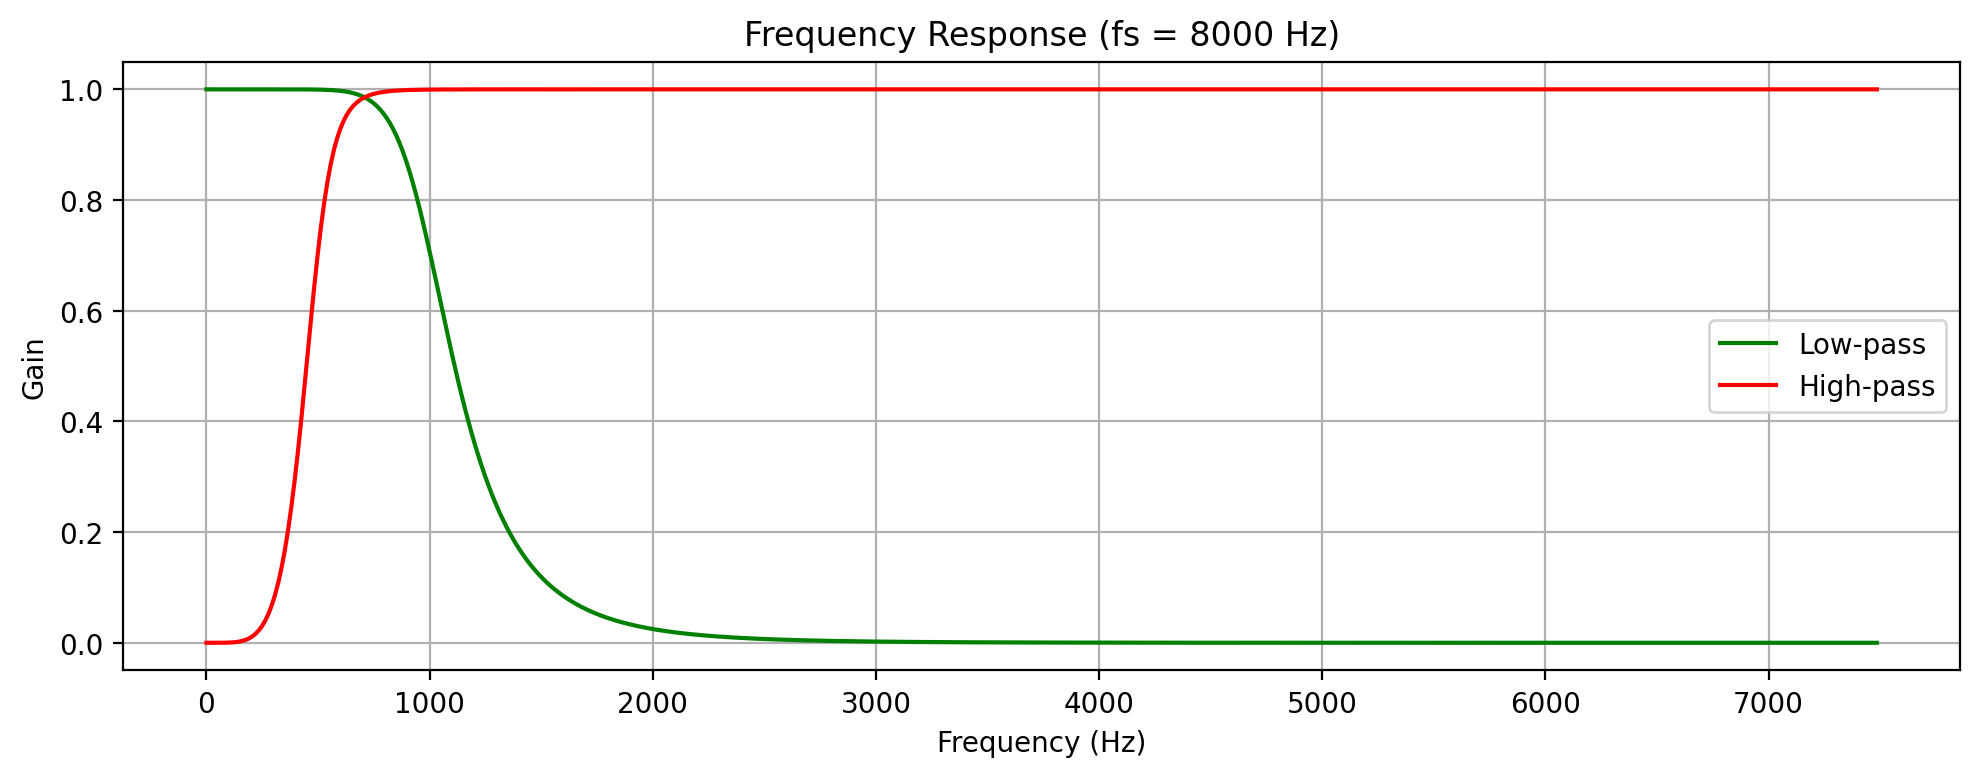

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(w_low, abs(h_low), label='Low-pass', color='green')
plt.plot(w_high, abs(h_high), label='High-pass', color='red')
plt.title('Frequency Response (fs = 8000 Hz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
combined = low_filtered + high_filtered
combined = combined / np.max(np.abs(combined))
combined_int16 = np.int16(combined * 32767)

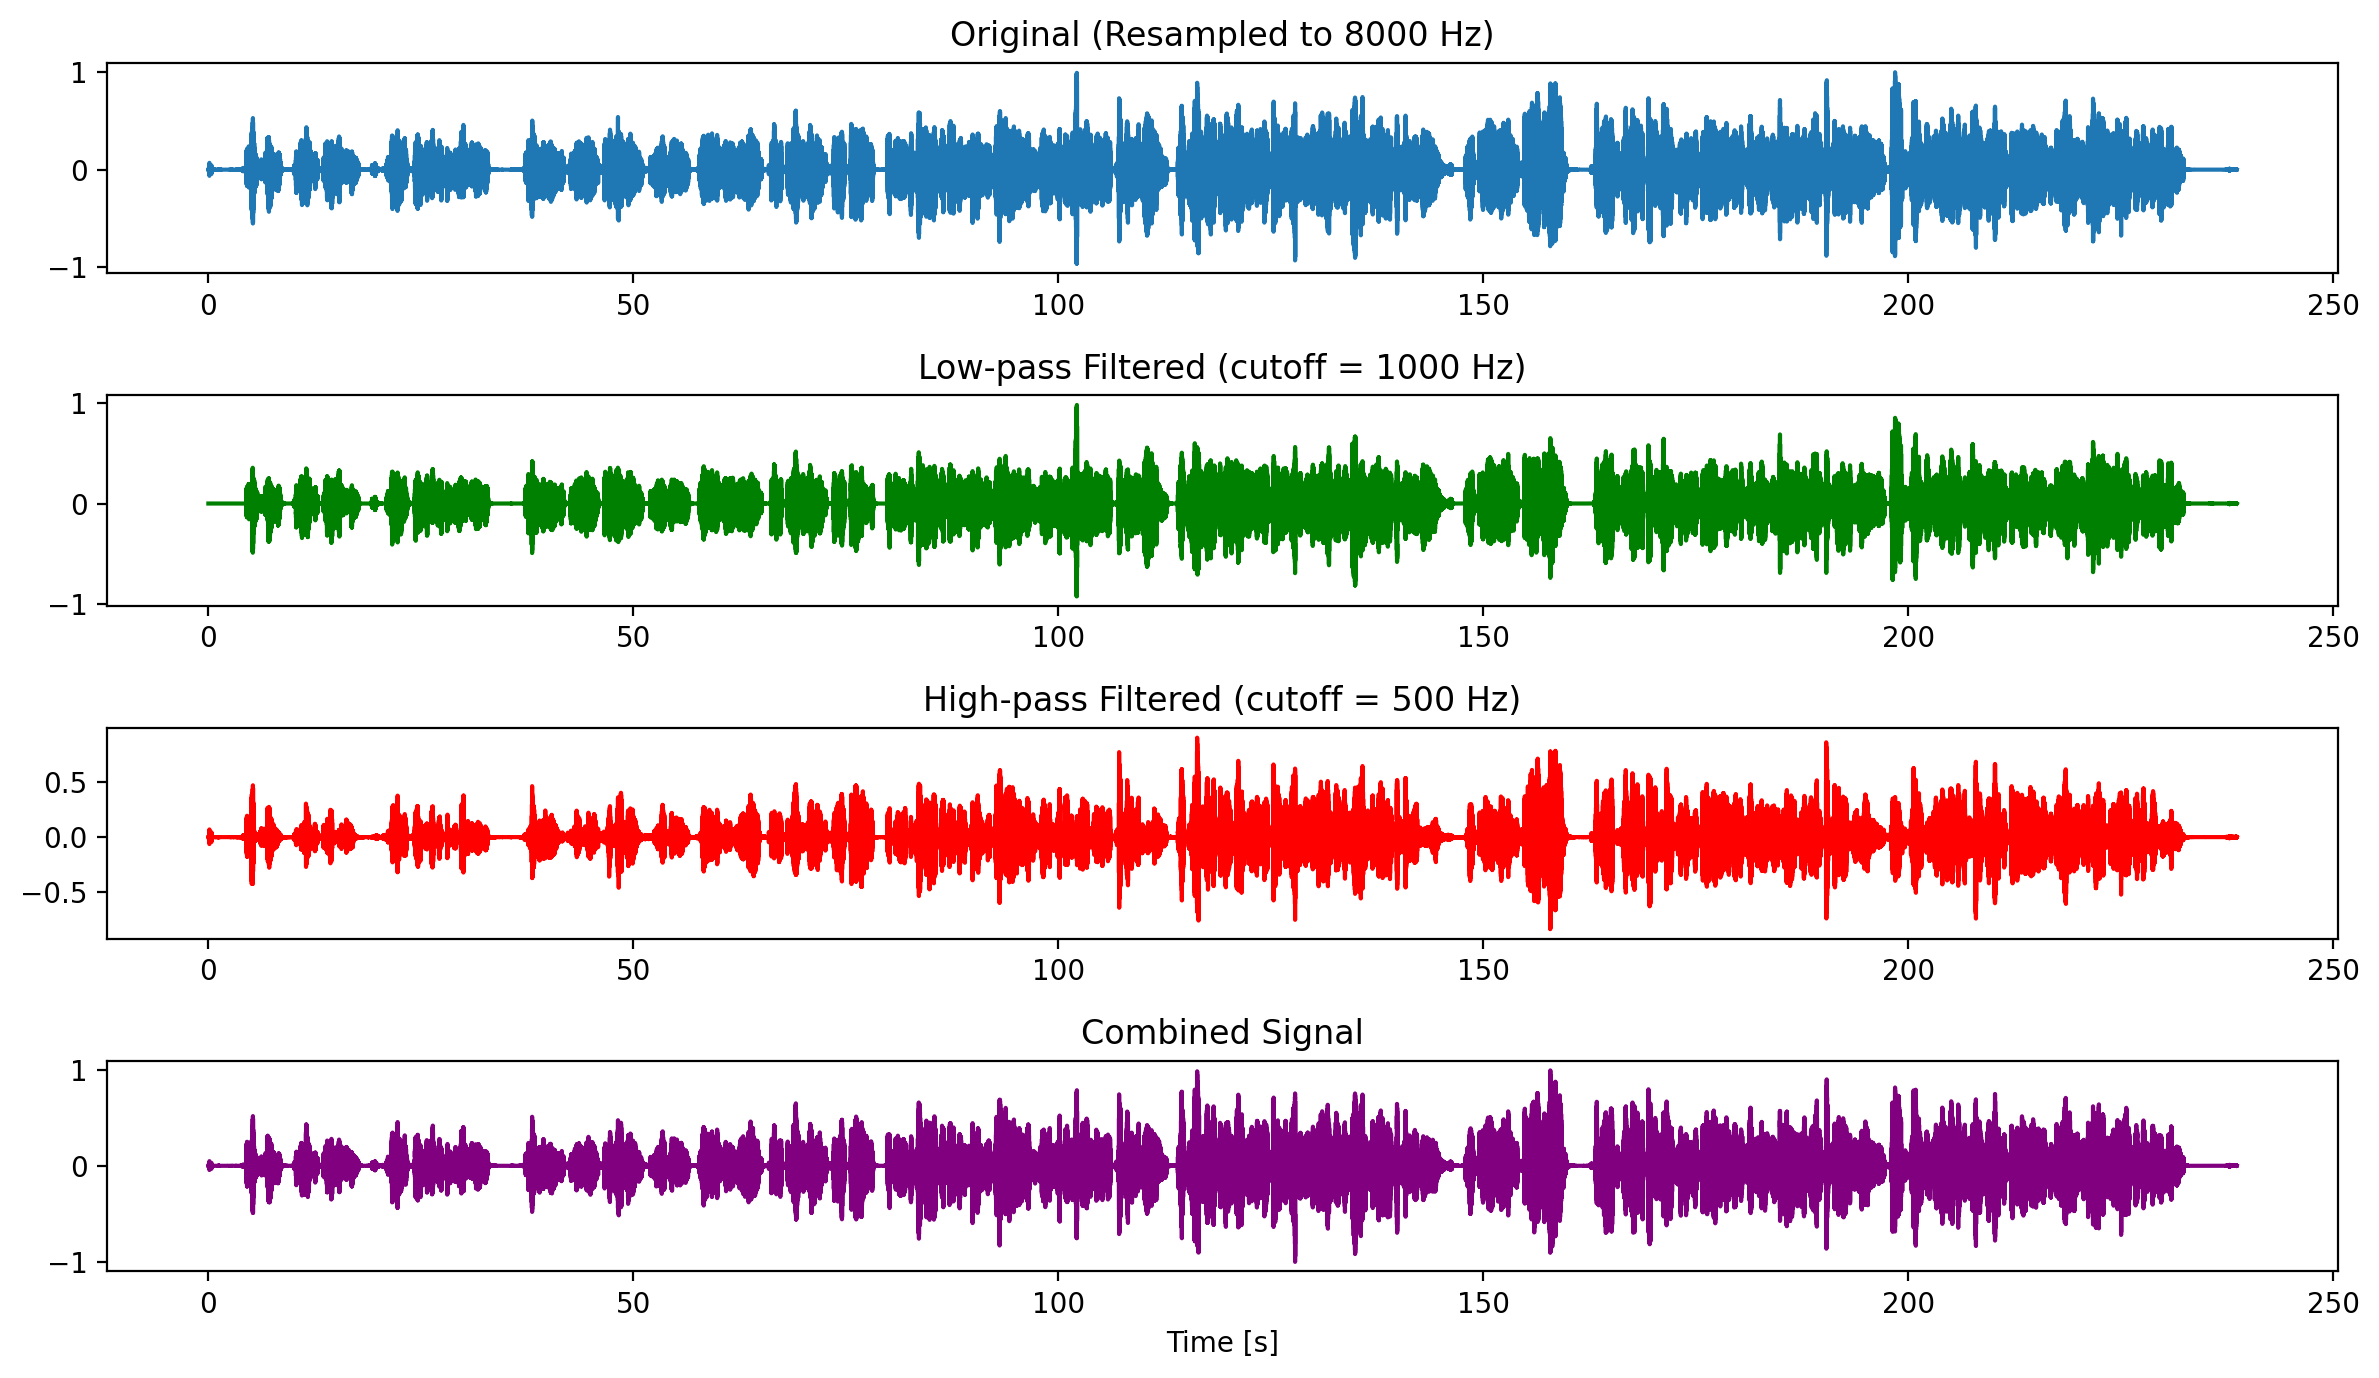

In [ ]:
plt.figure(figsize=(12, 7))

plt.subplot(4, 1, 1)
plt.plot(t, data_rs)
plt.title('Original (Resampled to 8000 Hz)')

plt.subplot(4, 1, 2)
plt.plot(t, low_filtered, color='green')
plt.title(f'Low-pass Filtered (cutoff = {low_cutoff} Hz)')

plt.subplot(4, 1, 3)
plt.plot(t, high_filtered, color='red')
plt.title(f'High-pass Filtered (cutoff = {high_cutoff} Hz)')

plt.subplot(4, 1, 4)
plt.plot(t, combined, color='purple')
plt.title('Combined Signal')

plt.xlabel('Time [s]')
plt.tight_layout()
plt.show()

In [ ]:
from scipy.io.wavfile import write

In [ ]:
combined = low_filtered + high_filtered
combined = combined / np.max(np.abs(combined))
combined_int16 = np.int16(combined * 32767)

# บันทึกไฟล์ wav
write('/content/drive/MyDrive/Datasets_For_Ai_builders/filter(แล้ว)/Tstfiltered_new_2.wav', fs, combined_int16)

เพลง Original

In [ ]:
path_2 = '/content/drive/MyDrive/Datasets_For_Ai_builders/CleanVoice/-  Tilly Birds _ The Wall Song _vocal.wav'

In [ ]:
fs2, data2 = wavfile.read(path_2)

In [ ]:
if data2.ndim > 1:
    data2 = data2.mean(axis=1)


In [ ]:
data2 = data2 / np.max(np.abs(data2))

In [ ]:
target_fs2 = 8000
num_samples = int(len(data2) * target_fs / fs2)
data_resampled = resample(data2, num_samples)
fs2 = target_fs2  # กำหนด fs ใหม่เป็น 8000
t = np.linspace(0, len(data_resampled) / fs, num=len(data_resampled))


In [ ]:
time2 = np.linspace(0, len(data2) / fs2, num=len(data2))

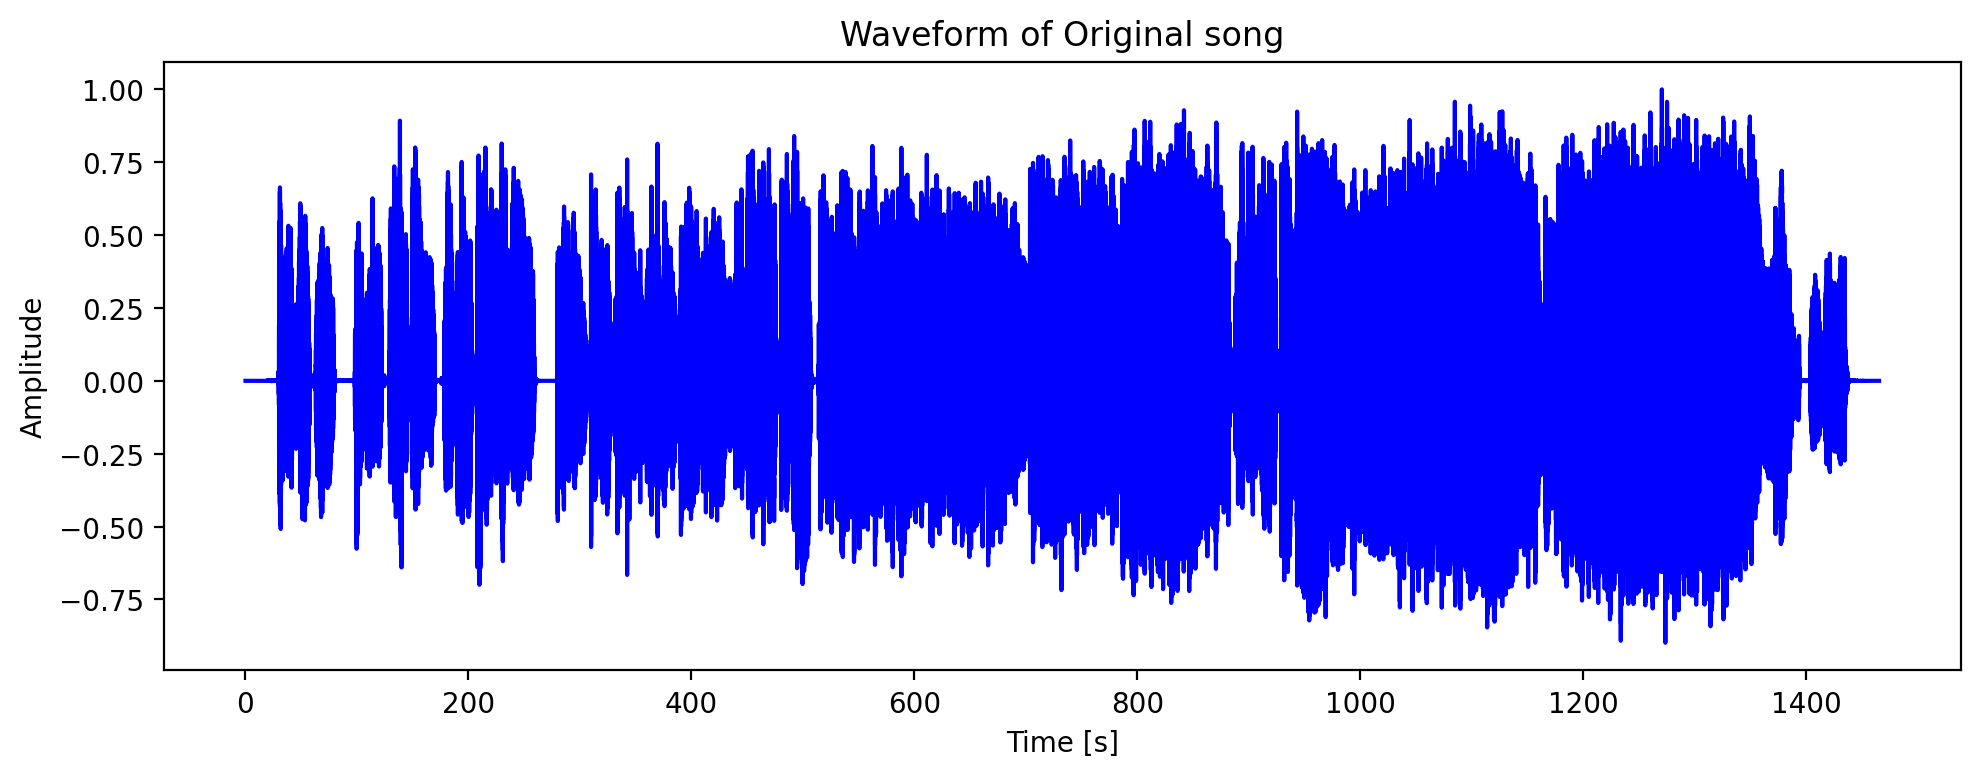

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(time2, data2, color='blue')
plt.title('Waveform of Original song')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

test

In [ ]:
import librosa
import noisereduce as nr
import soundfile as sf


y, sr = librosa.load("/content/drive/MyDrive/Datasets_For_Ai_builders/เสียงกูเอง (1)_vocal.wav", sr=None)
noise_sample = y[0:int(sr * 0.5)]
reduced_noise = nr.reduce_noise(y=y, sr=sr, y_noise=noise_sample)
max_val = np.max(np.abs(reduced_noise))
normalized_audio = reduced_noise / max_val * 1

sf.write("output_audio_4.wav", reduced_noise, sr)


# find key signature with DP model

In [ ]:
!pip install CREPE

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.8 MB/s eta 0:00:00
  Created wheel for CREPE: filename=crepe-0.0.16-py3-none-any.whl size=134848677 sha256=554640ec206a792a68dbd2c88446a15d7f3f8c1c9b2df1bd1d8d921699b6ffd1
  Stored in directory: /root/.cache/pip/wheels/fb/54/e2/e2d6bc065d4bbd6920e243682536fe85bb3b33daacbbeb9672
Successfully built CREPE


In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import crepe
import numpy as np
import seaborn as sns
import pandas as pd
from collections import Counter
from music21 import pitch, stream, note, key


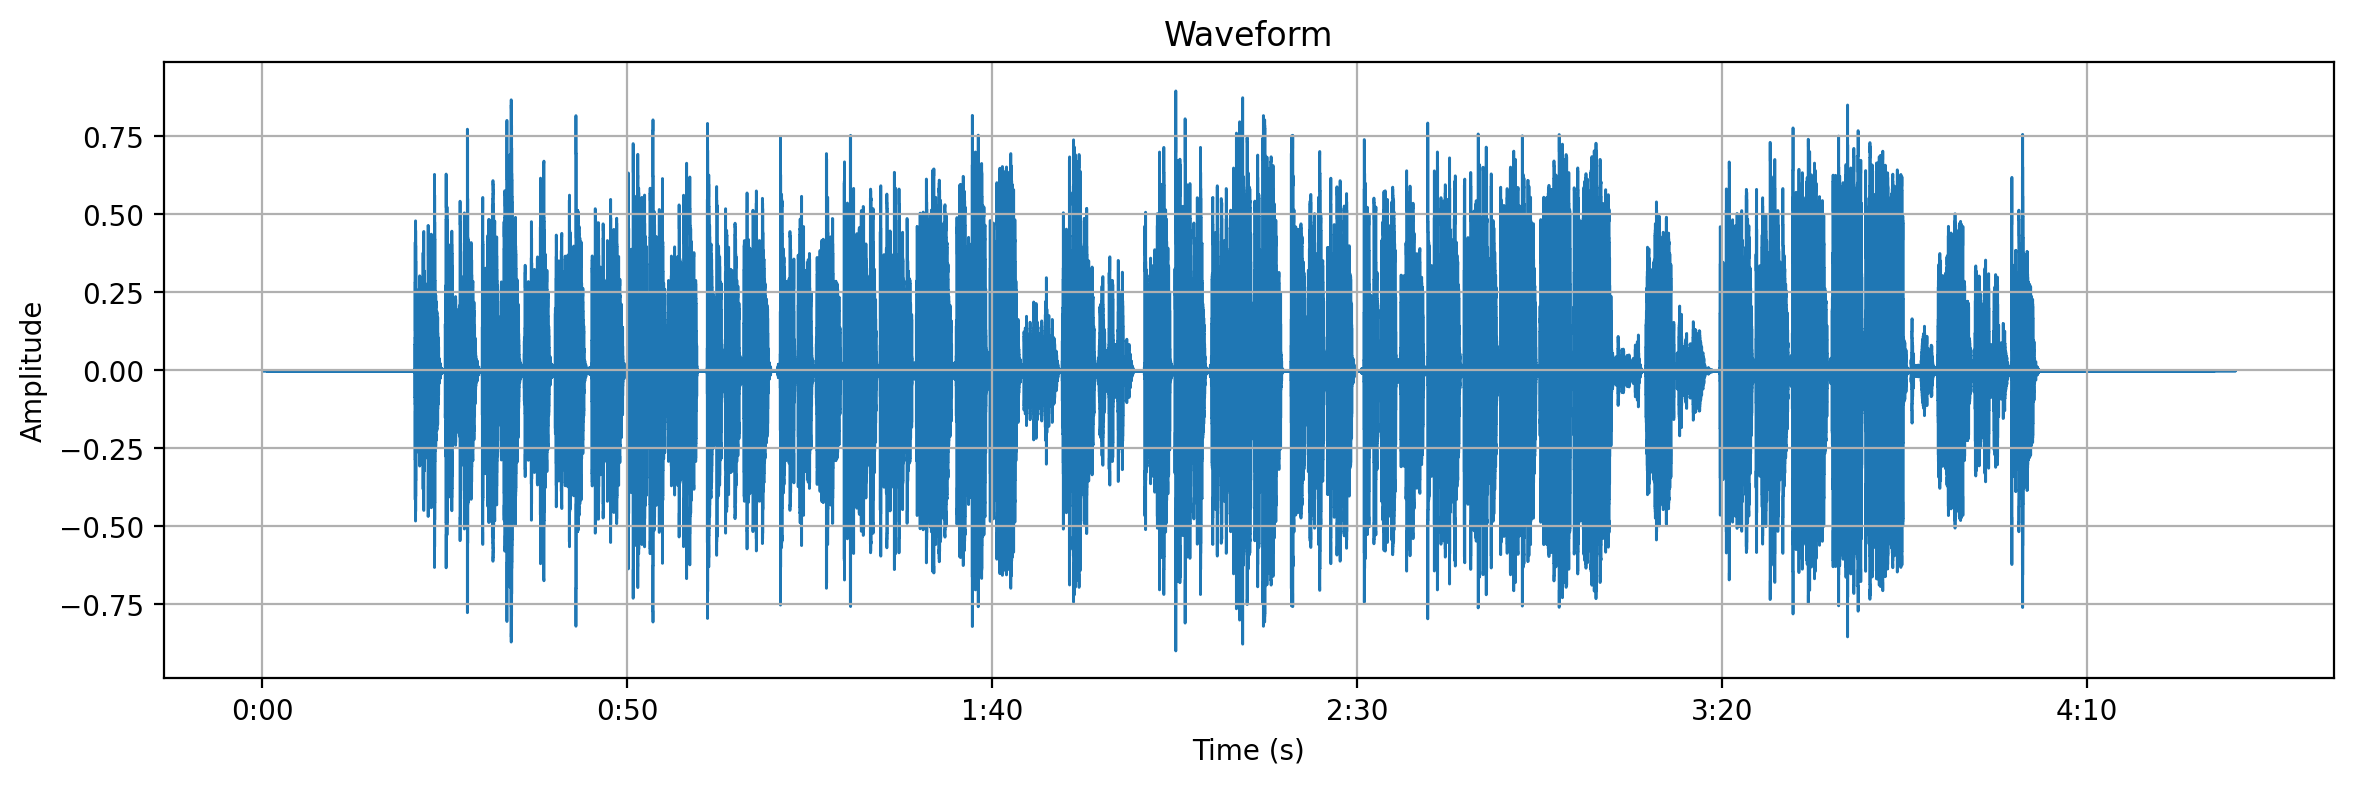

696/696 ━━━━━━━━━━━━━━━━━━━━ 229s 329ms/step
Key Signature: A major
Camelot Key: 11B


In [ ]:
file_path = '/content/drive/MyDrive/Datasets_For_Ai_builders/CleanVoice/-   POP PONGKOOL Official MV_vocal.wav'
y, sr = librosa.load(file_path, sr=16000, mono=True)

y_trimmed, _ = librosa.effects.trim(y, top_db=40)
# แสดง waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# ใช้ CREPE หาความถี่
time, frequency, confidence, _ = crepe.predict(y_trimmed, sr, viterbi=True, step_size=10)
threshold = 0.8
filtered_frequencies = frequency[confidence > threshold]

# แปลง pitch เป็นโน้ตและใส่ใน stream
s = stream.Stream()
for f in filtered_frequencies:
    try:
        p = pitch.Pitch()
        p.frequency = f
        n = note.Note(p)
        s.append(n)
    except:
        continue

# วิเคราะห์ key
key_signature = s.analyze('key')
print("Key Signature:", key_signature)

# แสดงชื่อคีย์แบบ Camelot
camelot_map = {
    'C major': '8B', 'G major': '9B', 'D major': '10B', 'A major': '11B', 'E major': '12B',
    'B major': '1B', 'F# major': '2B', 'C# major': '3B', 'G# major': '4B', 'D# major': '5B',
    'A# major': '6B', 'F major': '7B',

    'A minor': '8A', 'E minor': '9A', 'B minor': '10A', 'F# minor': '11A', 'C# minor': '12A',
    'G# minor': '1A', 'D# minor': '2A', 'A# minor': '3A', 'F minor': '4A', 'C minor': '5A',
    'G minor': '6A', 'D minor': '7A',
}

k_str = f"{key_signature.tonic.name} {key_signature.mode}"
camelot = camelot_map.get(k_str, "Unknown")
print("Camelot Key:", camelot)


#fine timbre (code backUp)

In [ ]:
import parselmouth
import joblib  # สำหรับ save/load โมเดล
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold

In [ ]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)

    # Fundamental frequency (f0)
    snd = parselmouth.Sound(file_path)
    pitch = snd.to_pitch()
    f0_mean = pitch.get_mean(0, 0, "Hertz")

    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)

    # Spectral Centroid
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    centroid_mean = np.mean(centroid)

    # Spectral Bandwidth
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    bandwidth_mean = np.mean(bandwidth)

    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr_mean = np.mean(zcr)

    return np.hstack([
        [f0_mean],
        mfcc_mean,
        [centroid_mean, bandwidth_mean, zcr_mean]
    ])

In [ ]:
def load_dataset(base_path):
    features = []
    labels = []
    for label, gender in enumerate(['male', 'female']):
        folder = os.path.join(base_path, gender)
        for file in os.listdir(folder):
            if file.endswith(".wav"):
                file_path = os.path.join(folder, file)
                try:
                    feats = extract_features(file_path)
                    features.append(feats)
                    labels.append(label)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
    return np.array(features), np.array(labels)

In [ ]:
dataset_path = 'dataset'  # เปลี่ยน path ตรงนี้ให้ตรงกับของคุณ
X, y = load_dataset(dataset_path)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

save model

In [ ]:
joblib.dump(model, 'voice_gender_model.pkl')

plot graph

In [ ]:
def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=5):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y,
        cv=StratifiedKFold(n_splits=cv),
        scoring='accuracy',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        shuffle=True,
        random_state=42
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
    plt.plot(train_sizes, val_mean, 'o-', label='Validation Accuracy')

    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_learning_curve(model, X, y, title="Random Forest Voice Gender Classification")

Test model

In [ ]:
model = joblib.load('voice_gender_model.pkl')

prediction

In [ ]:
features = extract_features('test_voice.wav')
prediction = model.predict([features])[0]

print("Predicted gender:", "Male" if prediction == 0 else "Female")

#Fine tune Model

extract feature from audio

In [8]:
!pip install ddsp

  Using cached ddsp-3.7.0-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached cloudml_hypertune-0.1.0.dev6-py2.py3-none-any.whl
  Using cached crepe-0.0.12.tar.gz (15 kB)
  Preparing metadata (setup.py) ... done
  Using cached dill-0.3.4-py2.py3-none-any.whl.metadata (9.6 kB)
  Using cached hmmlearn-0.2.7.tar.gz (53 kB)
  Preparing metadata (setup.py) ... done
  Using cached librosa-0.10.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached pydub-0.25.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached protobuf-3.20.0-py2.py3-none-any.whl.metadata (720 bytes)
  Using cached mir_eval-0.7.tar.gz (90 kB)
  Preparing metadata (setup.py) ... done
  Using cached note_seq-0.0.3-py3-none-any.whl.metadata (1.1 kB)
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
  Using cached scipy-1.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
INFO: pip is looking at multiple versions of ddsp to determine which ver

In [9]:
from ddsp.training.metrics import compute_loudness

ModuleNotFoundError: No module named 'ddsp'